# Políticas de Evacuación

A continuación se presenta un documento que describe en detalle las cuatro políticas implementadas, junto con su justificación de diseño, su pseudocódigo (y/o diagramas de flujo) y un breve análisis desde la perspectiva probabilística inspirada en Jaynes y su “robot” (el argumento epistemológico que usa supuestos y evidencias).

---

## 1. Explicación detallada de cada estrategia

### 1.1 **Política 1**
- **Objetivo**: Encontrar **un camino** desde el nodo inicial a **cualquier** nodo de extracción que sea lo más corto posible (minimizando la “distancia” o el `weight` en el grafo).
- **Recursos**: Se dividen de manera equitativa entre explosivos, munición (ammo) y trajes de radiación, y luego se reparte cualquier remanente.
- **Comportamiento**:
  1. Calcula la ruta de menor longitud con `nx.shortest_path` (o `nx.shortest_path_length` para obtener la distancia y luego la ruta).
  2. Si no hay ruta, la política asigna cero recursos.
  3. Si sí hay ruta, se toma la longitud de la ruta (o el número de nodos/tramos) como referencia para dividir los recursos.
  4. Finalmente, cualquier sobrante (el residuo de dividir entre 3) se asigna de forma aleatoria o equitativa a los diferentes tipos de recursos.

#### Justificación de diseño
- **Simplicidad**: Se asume que la prioridad principal es no malgastar recursos cuando no hay camino, y si lo hay, repartir los recursos equitativamente, ya que no se cuenta con información adicional de riesgos.
- **Enfoque minimalista**: No se tienen en cuenta condiciones del entorno (radiación, enemigos, etc.). Se busca esencialmente un atajo seguro minimizando el “peso” (distancia).

---

### 1.2 **Política 2**
- **Objetivo**: Encontrar **un camino más seguro**, considerando la información de `proxy_data` (riesgo en nodos y aristas).
- **Recursos**: Se asignan basados en la combinación de indicadores de riesgo a lo largo de la ruta:
  - Explosivos según indicadores de **daño estructural, actividad sísmica, integridad estructural**.
  - Munición según **avistamientos de movimiento, densidad poblacional, llamadas de emergencia**.
  - Trajes de radiación según **niveles de radiación**.
- **Comportamiento**:
  1. Se calcula un “riesgo” por cada nodo y arista usando la información de `proxy_data`.
  2. Se reasignan los `weight` en las aristas como la suma de sus indicadores más el promedio del riesgo de los nodos que conecta.
  3. Se busca el **camino de menor riesgo total** con `nx.shortest_path_length(..., weight='weight')`.
  4. Se recorre ese camino y se calculan cuántos explosivos, municiones y trajes se necesitan a partir de la lógica definida (por ejemplo, si `movement_sightings` es alto, se incrementa munición).
  5. Se limita la asignación al máximo de recursos disponibles (`max_resources`).

#### Justificación de diseño
- **Adaptación al riesgo**: La idea central es que no solo importa la distancia, sino la peligrosidad de cada ruta.
- **Distribución focalizada**: Asignar explosivos, municiones y trajes según la probabilidad de problemas estructurales, enemigos, radiación, etc., permite mayor eficiencia en la asignación.

---

### 1.3 **Política 3**
- **Objetivo**: Usar **datos de simulaciones previas** (implícitamente incorporados en `proxy_data`) para filtrar nodos/edges no viables y así encontrar la ruta con mejores probabilidades de éxito.
- **Recursos**: Se asignan tras elegir un camino que evita nodos con radiación letal y aristas muy peligrosas.
- **Comportamiento**:
  1. **Filtra** nodos cuyo `radiation_readings` sea demasiado alto (por ejemplo, ≥ 0.75), pues se consideran intransitables.
  2. **Filtra** aristas con `hazard_gradient` alto (≥ 0.7, por ejemplo).
  3. Recalcula el conjunto de nodos de extracción válidos (los que no fueron filtrados).
  4. Encuentra el **camino más corto** (por peso) dentro del subgrafo filtrado.
  5. Asigna recursos en función de reglas heurísticas (por ejemplo, necesidad de explosivos si integridad estructural del camino es baja, munición si hay alta densidad, etc.).

#### Justificación de diseño
- **Seguridad como prioridad**: Esta política directamente descarta zonas que, en la experiencia previa (simulaciones), ya demostraron ser inviables.
- **Eficiencia**: Evita gastar recursos en rutas que, en la práctica, han resultado imposibles o demasiado riesgosas.

---

### 1.4 **Política 4**
- **Objetivo**: **Mezclar** la lógica de la Política 3 (filtrar zonas críticas) con un análisis más **detallado y dinámico** del riesgo de cada tramo, usando múltiples indicadores.
- **Recursos**: Distribución “inteligente” que, además de cubrir mínimos esenciales, ajusta la cantidad final en función de puntuaciones de riesgo.
- **Comportamiento**:
  1. Calcula un **riesgo de nodo** (ej. combinando radiación, integridad estructural, densidad poblacional, etc.) y un **riesgo de arista** (ej. daños estructurales, escombros, movimiento, etc.).
  2. Encuentra la ruta con menor “peso” (donde el peso es una combinación de esos riesgos).
  3. Determina cuántos explosivos, trajes y munición se necesitan, tomando en cuenta umbrales de riesgo críticos (por ejemplo, `radiation_critical = 0.6`).
  4. Distribuye los recursos respetando `max_resources`, pero dándole prioridad a las necesidades más urgentes (ej. si hay nodos con radiación crítica).
  5. Ajusta la asignación sobrante según la proporción de riesgos acumulados en explosivos, munición o trajes.

#### Justificación de diseño
- **Optimización refinada**: Combina la idea de filtrar lo imposible con la de asignar los recursos de manera más granular.
- **Priorización**: Queda explícito que la radiación crítica o un colapso estructural merecen recursos obligatorios, mientras que riesgos medianos se traducen en asignaciones parciales.

---

## 2. Justificación de decisiones de diseño (resumen general)

- **Uso de NetworkX**: Se aprovechan algoritmos (`shortest_path`, `shortest_path_length`) para calcular rutas.
- **Distribución de recursos condicional**: Cada política asume un **modelo distinto** de amenazas; la primera (Policy 1) casi ignora riesgos, mientras que las demás (2, 3 y 4) van incorporando información medioambiental con diferente nivel de detalle.
- **Filtrado vs. Ajuste de pesos**:
  - **Política 3** elimina nodos/aristas “intransitables”.
  - **Políticas 2** y **4** ajustan los pesos para penalizar o bonificar caminos según peligrosidad, en vez de eliminarlos por completo.
- **Heurísticas vs. Ponderaciones**:  
  - **Política 2** y **4** hacen uso de heurísticas para determinar la asignación de cada recurso (si `movement_sightings >= 0.5`, etc.).
  - **Política 4** agrega la noción de “puntuaciones y proporciones” para refinar aún más.

---

## 3. Pseudocódigo o diagramas de flujo

### 3.1 Diagrama de flujo simplificado — Política 1

```mermaid
flowchart TB
    A[Inicio] --> B[Obtener grafo, nodo inicio y nodos extracción]
    B --> C[Para cada nodo de extracción, calcular camino más corto y su distancia]
    C --> D[Elegir el camino con menor distancia]
    D --> E{¿Hay camino válido?}
    E -- No --> F[Asignar 0 recursos y devolver]
    E -- Sí --> G[Dividir max_resources en 3 partes]
    G --> H[Repartir residuo en explosivos, ammo o suits]
    H --> I[Devolver ruta y recursos]

## 3.2 Pseudocódigo — Política 2

1. `node_risks[node] = suma_indicadores_desfavorables(node_data).`  
2. `edge_risk(u,v) = (node_risks[u] + node_risks[v]) / 2 + suma_indicadores_arista(u,v).`  
3. Ajustar `graph[u][v].weight = edge_risk(u,v).`  
4. `best_path = camino_de_riesgo_minimo(graph, start, extraction_nodes).`  
5. Para cada arista `(u,v)` en `best_path`, incrementar contadores de explosivos, munición, etc., según las condiciones definidas (ej. `structural_damage`, `movement_sightings`…).  
6. `resources = min(contador_explosivos, remaining), ...`.  
7. Retornar `(best_path, resources)`.

---

## 3.3 Diagrama de flujo simplificado — Política 3

```mermaid
flowchart TB
    A[Inicio] --> B[Filtrar nodos con radiación >= 0.75]
    B --> C[Filtrar aristas con hazard_gradient >= 0.7]
    C --> D[Construir subgrafo filtrado]
    D --> E[Encontrar rutas posibles a nodos de extracción]
    E --> F{¿Existe camino?}
    F -- No --> G[Devolver solo el nodo inicial y 0 recursos]
    F -- Sí --> H[Tomar ruta mínima en subgrafo]
    H --> I[Calcular necesidades de explosivos, ammo, suits]
    I --> J[Asignar recursos sin exceder max_resources]
    J --> K[Retornar ruta y recursos]

## 3.4 Pseudocódigo (simplificado) — Política 4

1. `node_risks[node] = combinar(factores_nodo).`  
2. `edge_risk(u,v) = combinar(riesgos_nodos_u_y_v) + factores_arista.`  
3. Ajustar `graph[u][v].weight = edge_risk(u,v).`  
4. `best_path = buscar_ruta_minima_riesgo(graph, start, extraction_nodes).`  
5. Para cada nodo/arista en `best_path`:  
   - Calcular cuánto se necesitan explosivos, munición y trajes (dependiendo de umbrales).  
   - Guardar estos recuentos en `resource_needs`.  
6. Distribuir recursos en función de:  
   - **Prioridad crítica** (p. ej. radiación letal).  
   - **Proporciones** calculadas con puntuaciones de riesgo para explosivos/munición/trajes.  
   - Asegurar que la suma sea ≤ `max_resources`.  
7. Retornar `(best_path, final_resources)`.

---

## 4. Análisis de la política desde la perspectiva de probabilidad de Jaynes y su robot

El físico **Edwin T. Jaynes** introdujo la noción de la probabilidad como un formalismo de la lógica de la incertidumbre (enfatizando la perspectiva bayesiana). Imaginando un “robot” que razona con la información disponible, cada política corresponde a un **modelo** con distintos supuestos:

### Política 1
- **Supuesto**: El único factor relevante es la distancia.  
- **Probabilidad (enfoque de Jaynes)**: El “robot” asigna probabilidad 1 a que la ruta más corta es la mejor, pues no se contemplan otras causas de fallo.  
- **Límite**: Ignora la existencia de peligros, por lo que su “prior” es muy simplificado (o errado si hay riesgos ocultos).

### Política 2
- **Supuesto**: Se asume que el riesgo puede modelarse linealmente sumando indicadores de nodos y aristas.  
- **Probabilidad**: El “robot” estima la probabilidad de que una ruta sea “segura” en función de la suma de estos factores.  
- **Límite**: No contempla correlaciones complejas (p. ej. que la radiación y la densidad poblacional puedan darse juntas o excluirse mutuamente).

### Política 3
- **Supuesto**: Se cree que nodos con radiación alta y aristas con gradiente alto son intrínsecamente inviables. Equivale a asignarles probabilidad 0 (o muy cercana a 0) de ser transitables.  
- **Ventaja**: El robot, basado en datos de simulaciones, “aprende” a descartar caminos fatales.  
- **Límite**: El descarte total puede ser excesivo si, en realidad, hubiera escenarios donde se podría pasar con determinados recursos de protección.

### Política 4
- **Supuesto**: Asume que el riesgo es combinatorio y que algunos factores críticos hacen indispensable cierto recurso.  
- **Probabilidad**: El robot combina varios “prior” (o heurísticas) y ajusta la asignación según la suma de riesgos detectados.  
- **Límite**: Sigue siendo un modelo heurístico. No hay un cálculo de probabilidad bayesiana exacta, sino un sistema de “pesos y umbrales”.

En conjunto, cada política puede verse como un “robot” con distinta asignación de probabilidades (y distintos supuestos sobre la relevancia de cada indicador). Jaynes diría que la más “completa” será la que incorpore la mayor evidencia y la use de forma coherente (sin inconsistencias), lo cual se acerca a la **Política 4**, que intenta balancear múltiples factores.

---

### Palabras finales
Estas cuatro políticas ilustran desde un enfoque “mínimo” (**Política 1**) hasta un enfoque “maximalista” (**Política 4**) la toma de decisiones con información parcial. Cada una encaja en un modelo probabilístico diferente: cuanto más complejos son los indicadores y reglas, más compleja la **función de probabilidad** que el “robot” necesita estimar para elegir la ruta y asignar recursos de manera óptima.


### Política 1  
- Encuentra el path más corto.  
- Relativamente buena en supervivencia con uso semi-eficiente de recursos.  

### Política 2  
- Mayor eficiencia en el uso de recursos.  
- Disminuye ligeramente la tasa de supervivencia.  

### Política 3  
- Muy eficiente en cantidad de recursos utilizados.  
- Supervivencia prácticamente nula.  
- **No se considera una solución eficiente**.  

### Política 4  
- Eficiencia de recursos disminuye nuevamente.  
- Tasa de supervivencia aumenta a más del 30%.  

# Análisis de Resultados 
Política Uno

![WhatsApp Image 2025-03-07 at 17.04.23_d8b43a7b.jpg](<attachment:WhatsApp Image 2025-03-07 at 17.04.23_d8b43a7b.jpg>)
![WhatsApp Image 2025-03-07 at 17.04.23_341ee0b9.jpg](<attachment:WhatsApp Image 2025-03-07 at 17.04.23_341ee0b9.jpg>)

Conclusiones
Las evacuaciones fueron exitosas en el 61% de los casos, pero con alta variabilidad.
Las ciudades más grandes tuvieron más fallas, en particular la de tamaño 50 con 0% de éxito.
La eficiencia en el uso de recursos es moderada (52.3%), siendo los trajes anti-radiación los más eficientes (72.8%) y los explosivos los menos eficientes (30.5%).
Las llamadas de emergencia parecen correlacionarse con la actividad sísmica y la densidad de población, indicando posibles patrones de evacuación más predecibles.

Política dos

![WhatsApp Image 2025-03-07 at 17.12.47_9a6af376.jpg](<attachment:WhatsApp Image 2025-03-07 at 17.12.47_9a6af376.jpg>)
![WhatsApp Image 2025-03-07 at 17.12.48_34cb8d6c.jpg](<attachment:WhatsApp Image 2025-03-07 at 17.12.48_34cb8d6c.jpg>)

Conclusiones
La tasa de éxito cayó de 61% a 25%, lo que indica un problema grave en la nueva configuración.
Las ciudades más grandes fracasaron por completo.
El uso de recursos mejoró ligeramente, pero los explosivos siguen siendo los menos eficientes.
Puede haber un problema con la estrategia de evacuación o con los factores ambientales que impiden una evacuación eficiente.


Política tres

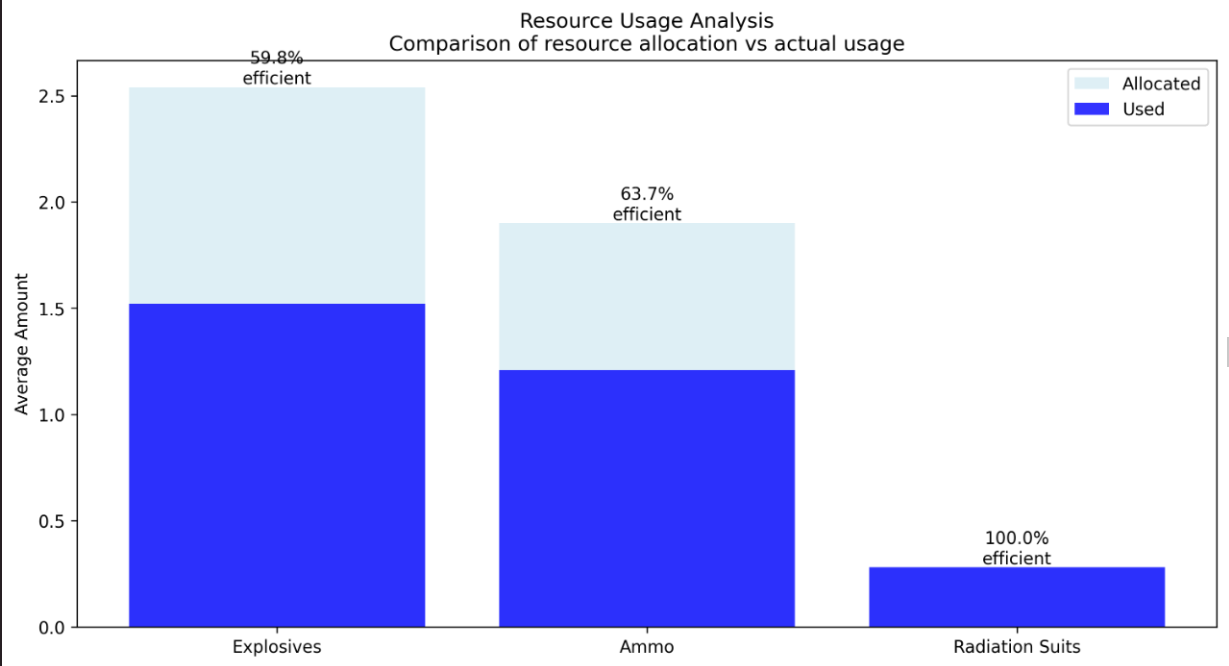
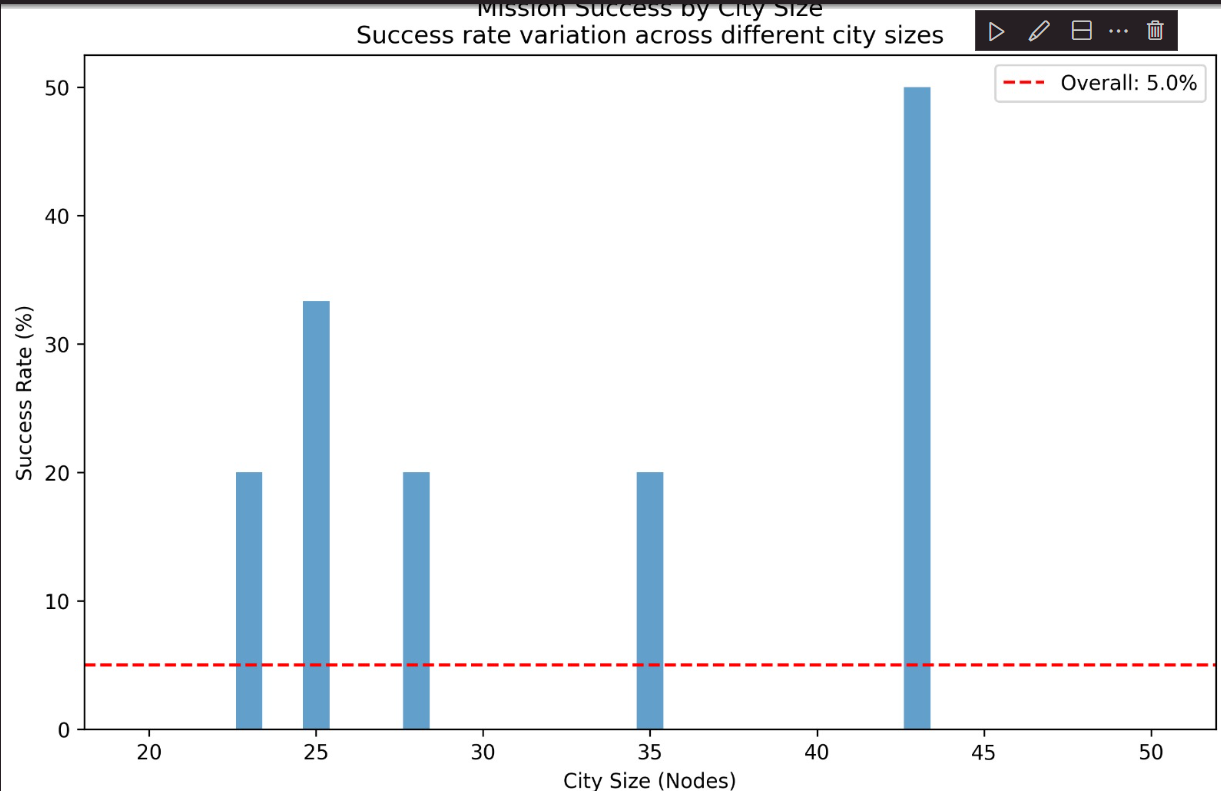

Conclusiones
La tasa de éxito cayó a casi el 0%, lo que indica que estamos sacrificando el éxito de la misión por un mínimo porcentaje de mejora en la eficiencia de los recursos.
Todas las ciudades fracasaron por completo.
El uso de recursos mejoró ligeramente, pero los explosivos siguen siendo los menos eficientes y los trajes aumentaron a 100% en su eficiencia.

Política cuatro

![WhatsApp Image 2025-03-07 at 17.35.45_cae63981.jpg](<attachment:WhatsApp Image 2025-03-07 at 17.35.45_cae63981.jpg>)
![WhatsApp Image 2025-03-07 at 17.35.52_d45126d5.jpg](<attachment:WhatsApp Image 2025-03-07 at 17.35.52_d45126d5.jpg>)

El análisis muestra que no es efectiva en su estado actual. La tasa de éxito es extremadamente baja y el uso de recursos es ineficiente.

### **Justificación de Métricas en la Política de Evacuación**

A continuación, se detallan las métricas seleccionadas en la política de evacuación, explicando su importancia y relación con el éxito de la misión. También se incluyen ejemplos concretos de su uso en el código.

---

## **1. Métricas de Evaluación del Entorno**

### **1.1 Actividad Sísmica (`seismic_activity`)**
📌 **Importancia:**  
- Determina la estabilidad estructural de los edificios y la posibilidad de derrumbes durante la evacuación.  
- Niveles altos de actividad sísmica aumentan el riesgo en ciertas rutas y podrían requerir explosivos para despejar caminos bloqueados.  

🔗 **Relación con el éxito de la misión:**  
- Una evacuación efectiva evita áreas con alta actividad sísmica o requiere estrategias para sortearlas.  
- Si no se considera, podría llevar a caminos colapsados e inviabilidad de la evacuación.

🛠 **Ejemplo en el código:**  
```python
seismic_activity = node_data.get('seismic_activity', 0)
```
Se usa para calcular el **riesgo de nodos** y ajustar los pesos de las rutas en la política `_policy_2`.

---

### **1.2 Radiación Ambiental (`radiation_readings`)**
📌 **Importancia:**  
- Afecta la seguridad de los evacuados y la necesidad de trajes de radiación.  
- En niveles letales, ciertos caminos deben evitarse por completo.  

🔗 **Relación con el éxito de la misión:**  
- Ignorar esta métrica puede llevar a una evacuación fallida con víctimas expuestas a radiación extrema.  
- Se usa para priorizar el suministro de trajes de radiación y ajustar la selección de rutas.

🛠 **Ejemplo en el código:**  
```python
radiation = node_data.get('radiation_readings', 0)
if radiation >= 0.5:
    suits_needed += 1
```
Se usa en `_policy_2` y `_policy_3` para determinar si es necesario equipar trajes de radiación en ciertas rutas.

---

### **1.3 Densidad Poblacional (`population_density`)**
📌 **Importancia:**  
- Indica la cantidad de personas en un área, lo que puede influir en la accesibilidad de las rutas y la necesidad de munición.  
- Zonas densamente pobladas pueden tener más incidentes de violencia o disturbios.  

🔗 **Relación con el éxito de la misión:**  
- Una evacuación bien planificada evita zonas densamente pobladas que pueden generar bloqueos.  
- También ayuda a prever necesidades de munición para defensa en caso de disturbios.

🛠 **Ejemplo en el código:**  
```python
population_density = node_data.get('population_density', 0)
if population_density >= 0.7:
    total = edge_movement + node_emergency + population_density
```
Se usa en `_policy_2` para determinar la necesidad de munición.

---

### **1.4 Llamadas de Emergencia (`emergency_calls`)**
📌 **Importancia:**  
- Indica niveles de pánico o incidentes en ciertas áreas.  
- Puede sugerir la presencia de peligros como incendios, colapsos o violencia.  

🔗 **Relación con el éxito de la misión:**  
- Áreas con muchas llamadas de emergencia pueden ser más peligrosas o tener obstáculos inesperados.  
- Se utilizan para ajustar la planificación de rutas y la asignación de recursos de seguridad.

🛠 **Ejemplo en el código:**  
```python
node_emergency = (node_u_data.get('emergency_calls', 0) + node_v_data.get('emergency_calls', 0)) / 2
```
Se usa en `_policy_2` para evaluar si se necesita munición en ciertas rutas.

---

## **2. Métricas de Evaluación de Rutas y Obstáculos**

### **2.1 Daño Estructural (`structural_damage`)**
📌 **Importancia:**  
- Representa el nivel de deterioro de caminos y estructuras.  
- Afecta la posibilidad de atravesar ciertas rutas sin el uso de explosivos.  

🔗 **Relación con el éxito de la misión:**  
- Rutas con alto daño estructural pueden ser intransitables, causando bloqueos en la evacuación.  
- Se usa para priorizar caminos seguros y estimar la necesidad de explosivos.

🛠 **Ejemplo en el código:**  
```python
edge_structural_damage = edge_data.get('structural_damage', 0)
if (edge_structural_damage + node_vulnerability + seismic_activity)/3 >= 0.5:
    explosives_needed += 1
```
Se usa en `_policy_2` para determinar cuándo se deben asignar explosivos.

---

### **2.2 Densidad de Escombros (`debris_density`)**
📌 **Importancia:**  
- Determina si una ruta está despejada o bloqueada por desechos y materiales colapsados.  
- Influye en la velocidad de evacuación y la necesidad de herramientas o explosivos para despejar el camino.  

🔗 **Relación con el éxito de la misión:**  
- Ignorar esta métrica puede llevar a retrasos y rutas inutilizables.  
- Se considera para modificar los pesos de las rutas y calcular la viabilidad de la evacuación.

🛠 **Ejemplo en el código:**  
```python
debris_density = edge_data.get('debris_density', 0)
edge_risk = debris_density + hazard_gradient
```
Se usa en `_policy_2` para ajustar los pesos de las rutas en función de la acumulación de escombros.

---

### **2.3 Interferencia de Señal (`signal_interference`)**
📌 **Importancia:**  
- Indica la calidad de comunicación en la zona.  
- Puede afectar la coordinación de la evacuación y la capacidad de recibir actualizaciones en tiempo real.  

🔗 **Relación con el éxito de la misión:**  
- Una evacuación sin comunicación efectiva es más propensa a fallar.  
- Se usa para ajustar la confiabilidad de ciertas rutas.

🛠 **Ejemplo en el código:**  
```python
signal_strength = node_data.get('signal_strength', 1)
risk = (1 - signal_strength)
```
Se usa en `_policy_2` para incluir la interferencia de señal en el cálculo del riesgo.

---

## **3. Métricas de Desempeño y Recursos**

### **3.1 Longitud del Camino (`path_length`)**
📌 **Importancia:**  
- La distancia total de evacuación afecta el tiempo necesario para llegar a un punto seguro.  

🔗 **Relación con el éxito de la misión:**  
- Cuanto más corto el camino, mayor probabilidad de éxito.  
- Se usa para seleccionar rutas óptimas en cada política.

🛠 **Ejemplo en el código:**  
```python
path_length = nx.shortest_path_length(adjusted_graph, start, target, weight='weight')
```
Se usa en `_policy_2` para calcular rutas eficientes.

---

### **3.2 Recursos Utilizados (`resources_used`)**
📌 **Importancia:**  
- Medir cuántos explosivos, municiones y trajes de radiación se usaron permite optimizar la planificación.  

🔗 **Relación con el éxito de la misión:**  
- Un uso eficiente de recursos mejora la probabilidad de evacuación exitosa sin desperdiciar suministros.  

🛠 **Ejemplo en el código:**  
```python
resources = {
    'explosives': explosives,
    'ammo': ammo,
    'radiation_suits': suits
}
```
Se usa en todas las políticas para distribuir los recursos de manera óptima.

---

### **Conclusión**
Las métricas utilizadas permiten modelar los riesgos de la evacuación y ajustar las estrategias de respuesta. Considerar estos factores permite mejorar la tasa de éxito, minimizar riesgos y optimizar el uso de recursos en escenarios de evacuación.


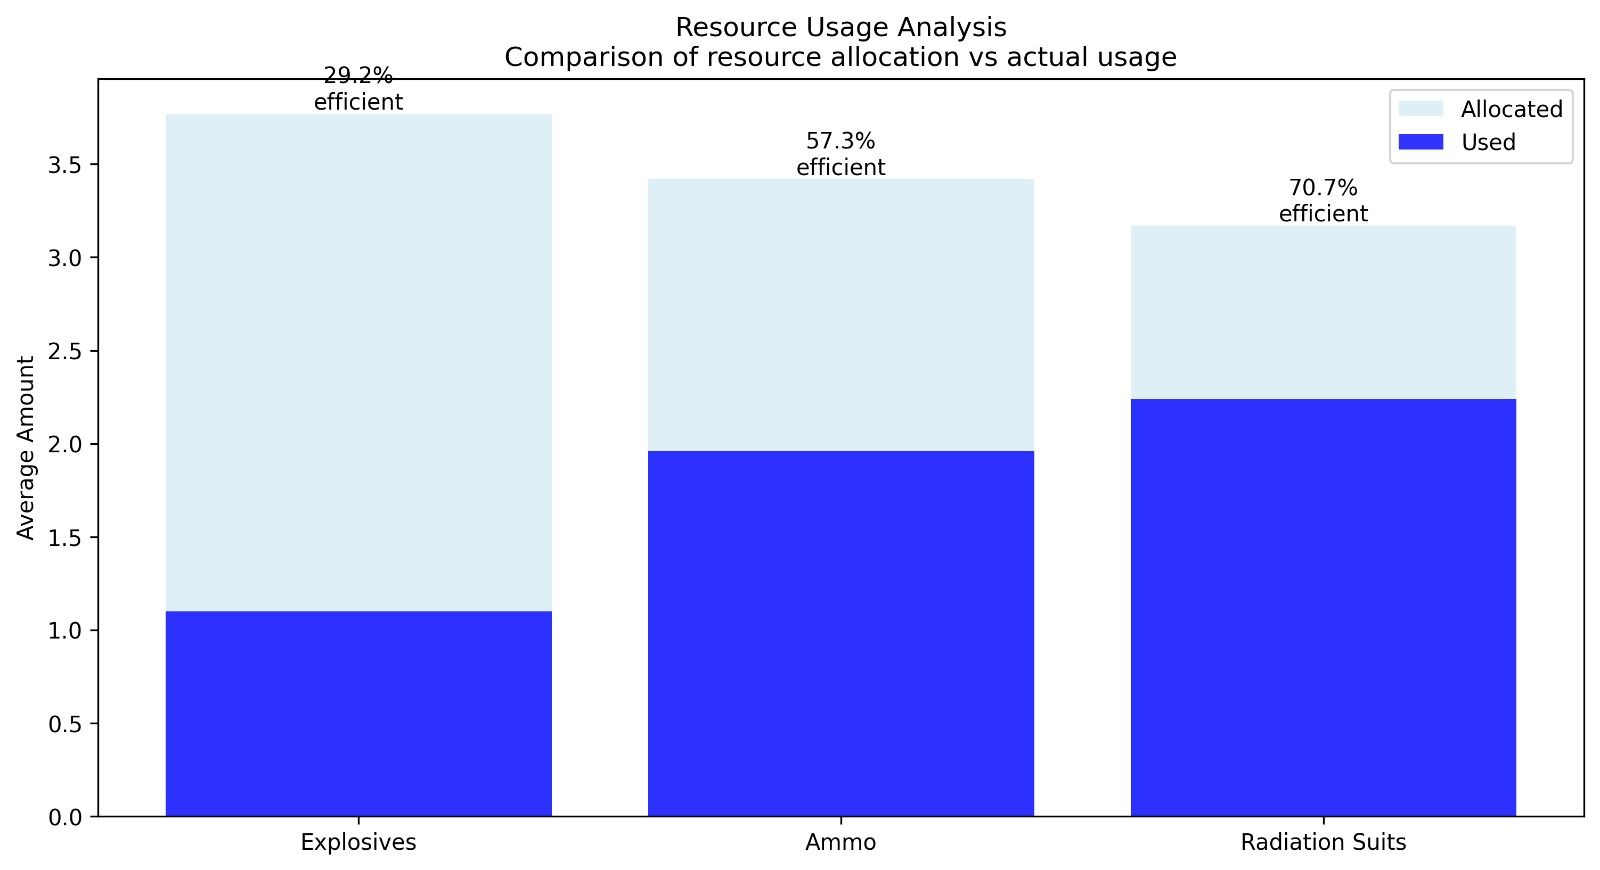
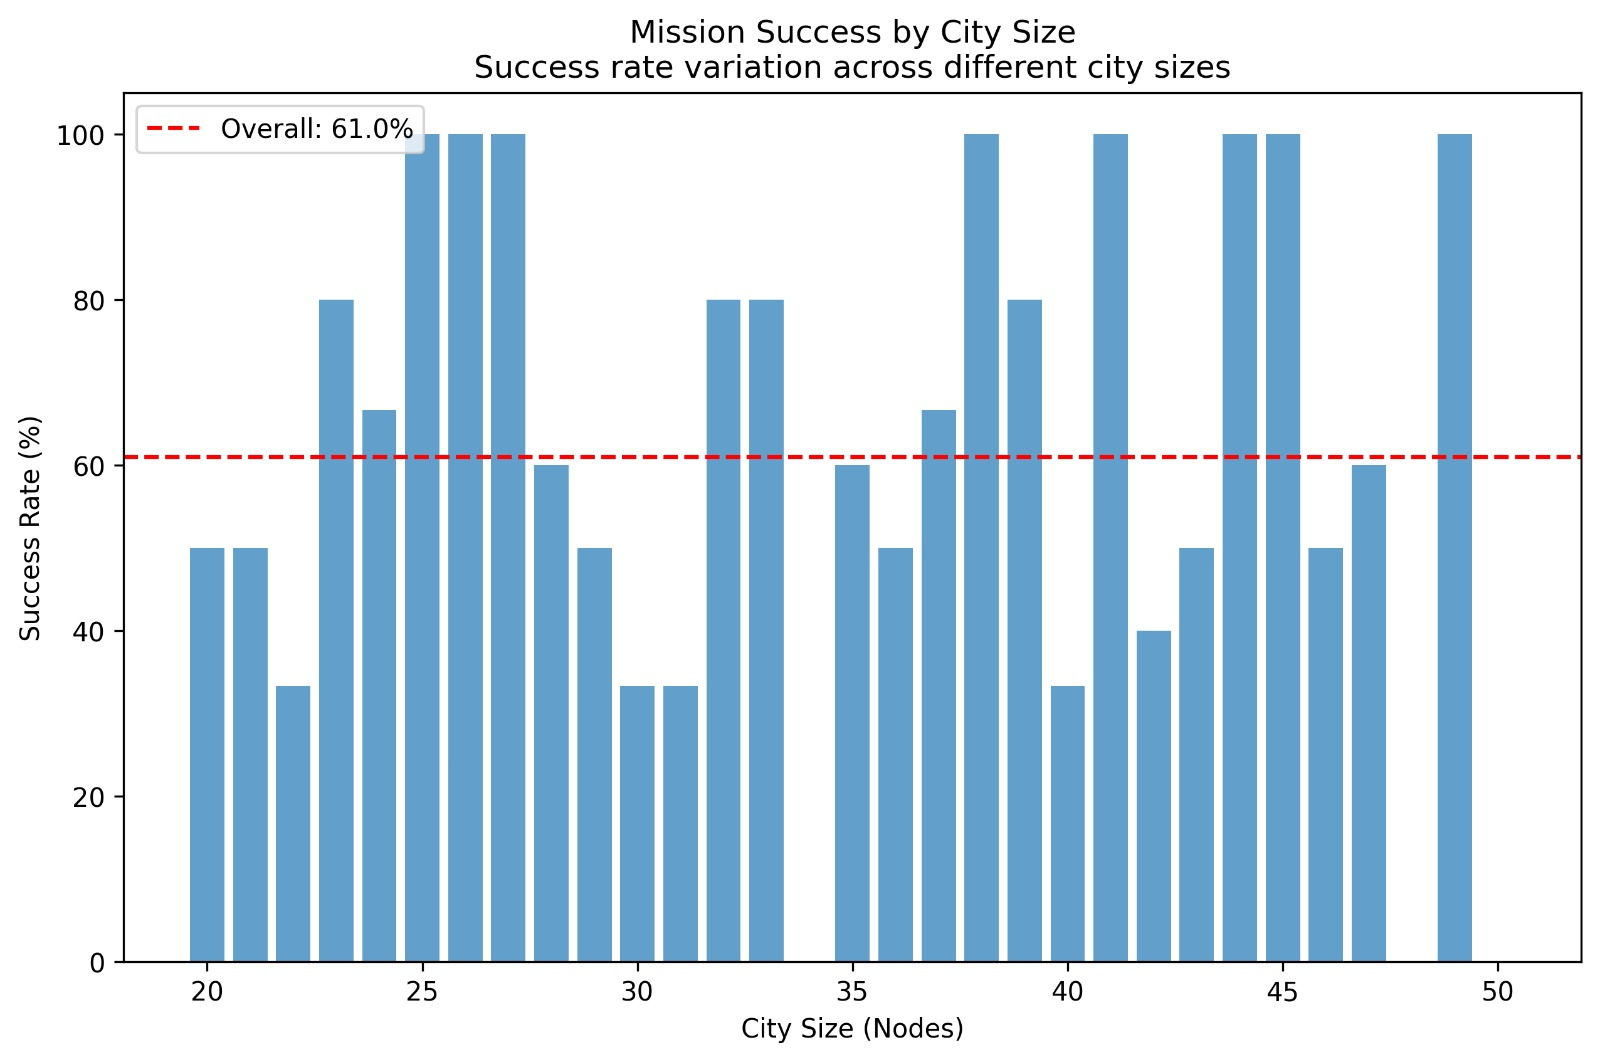
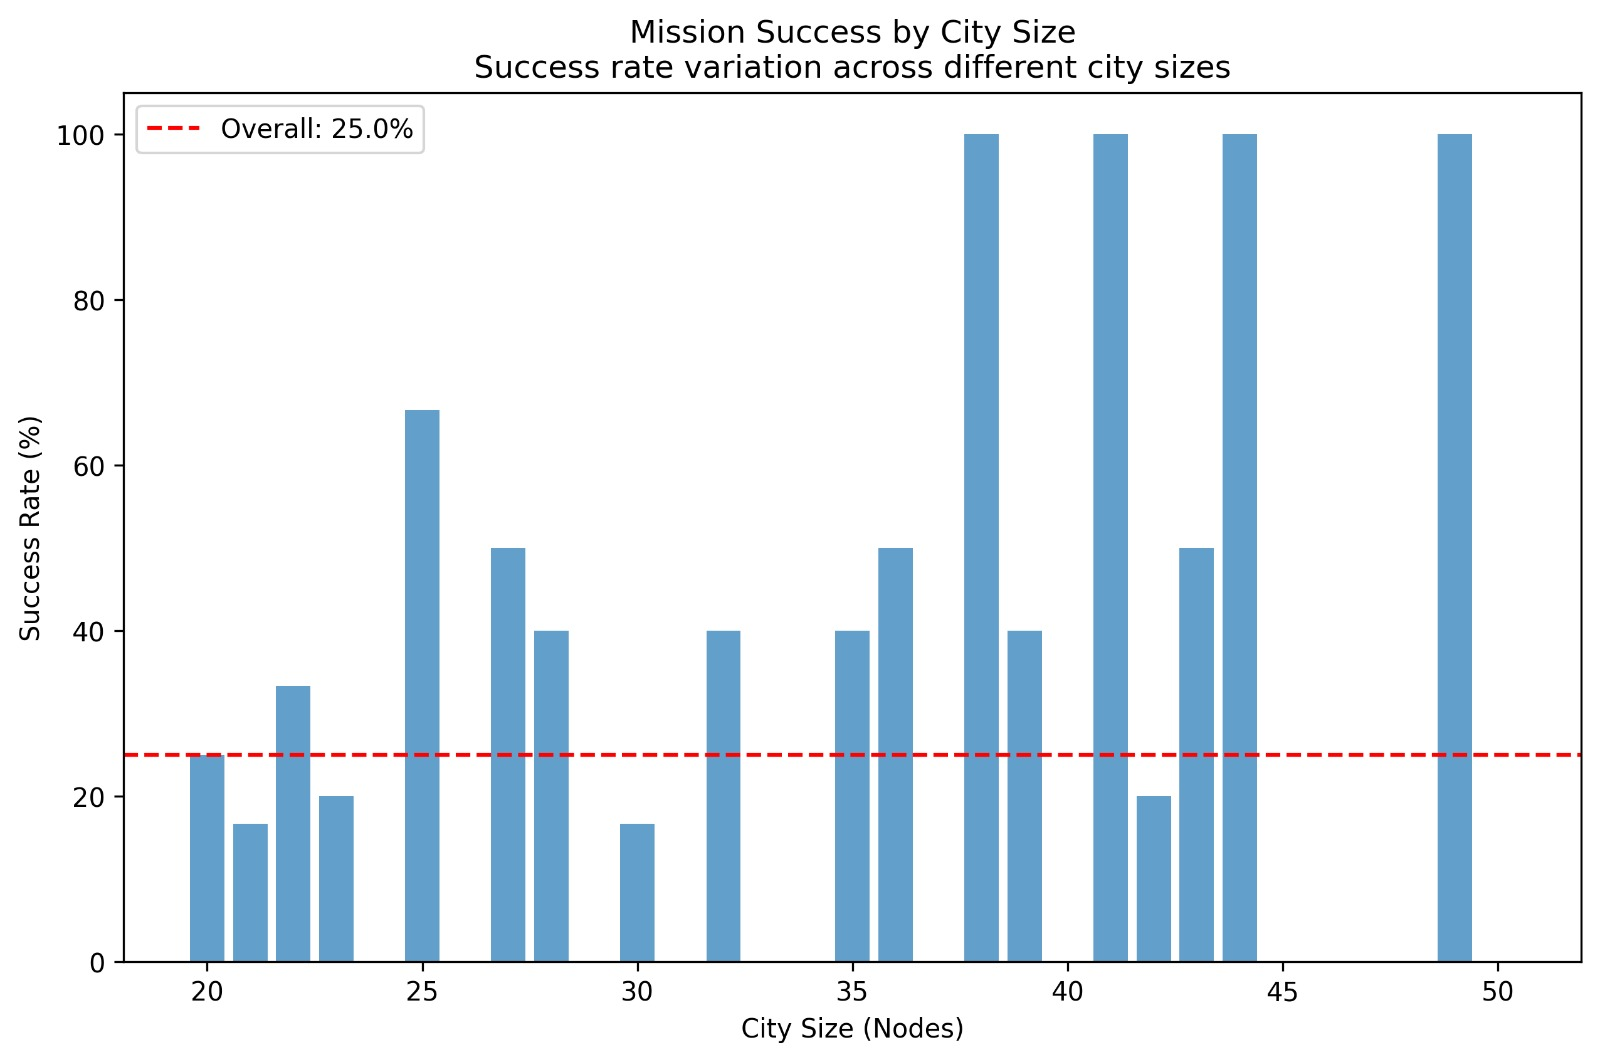
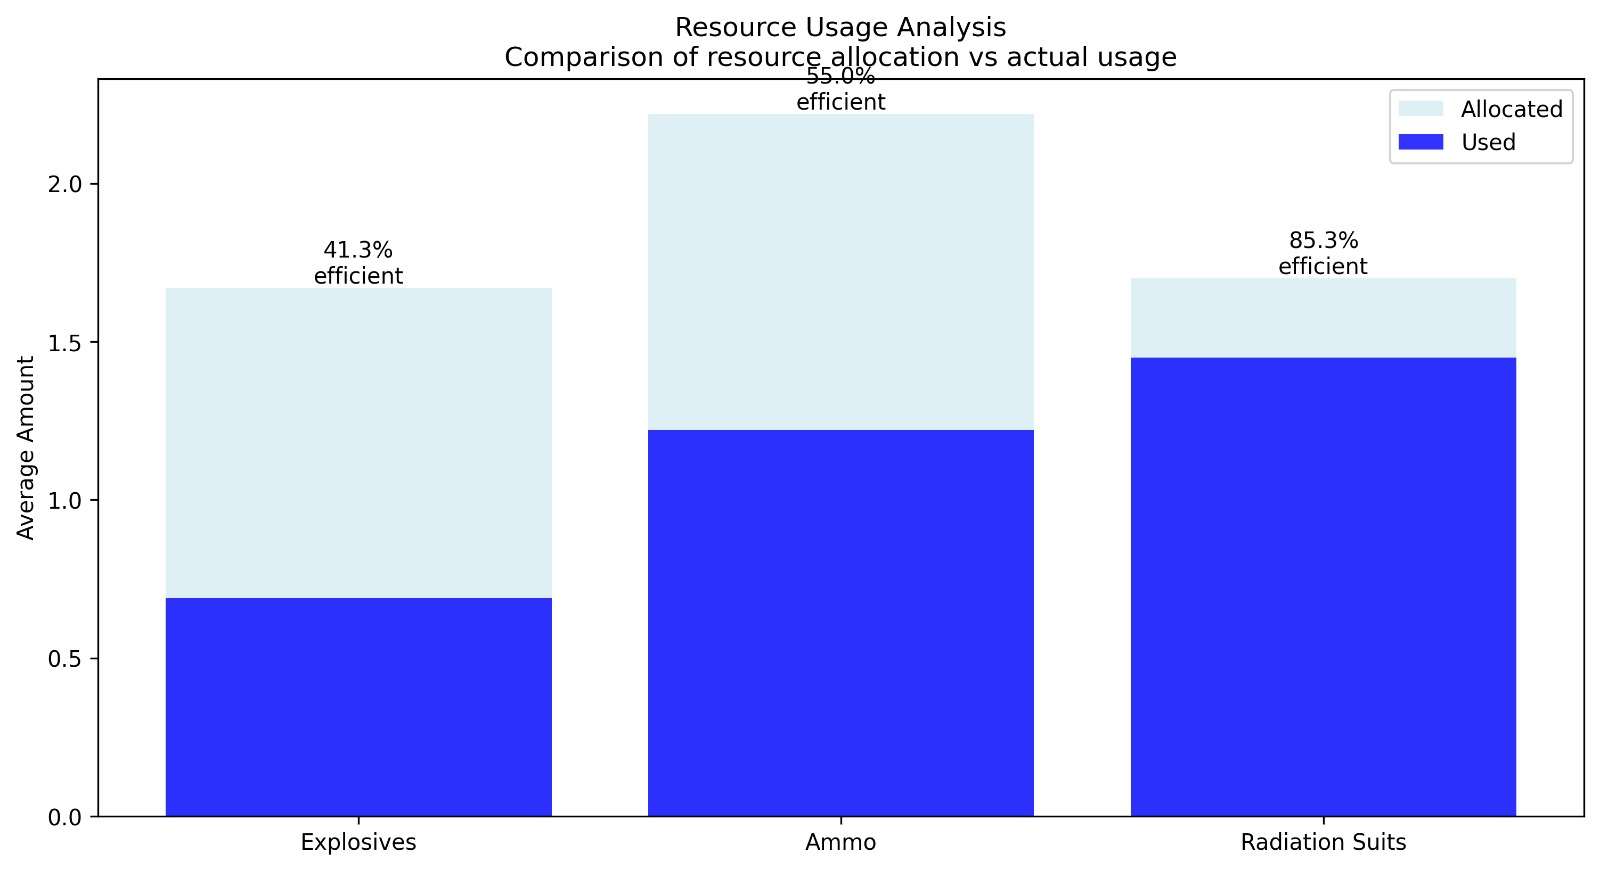
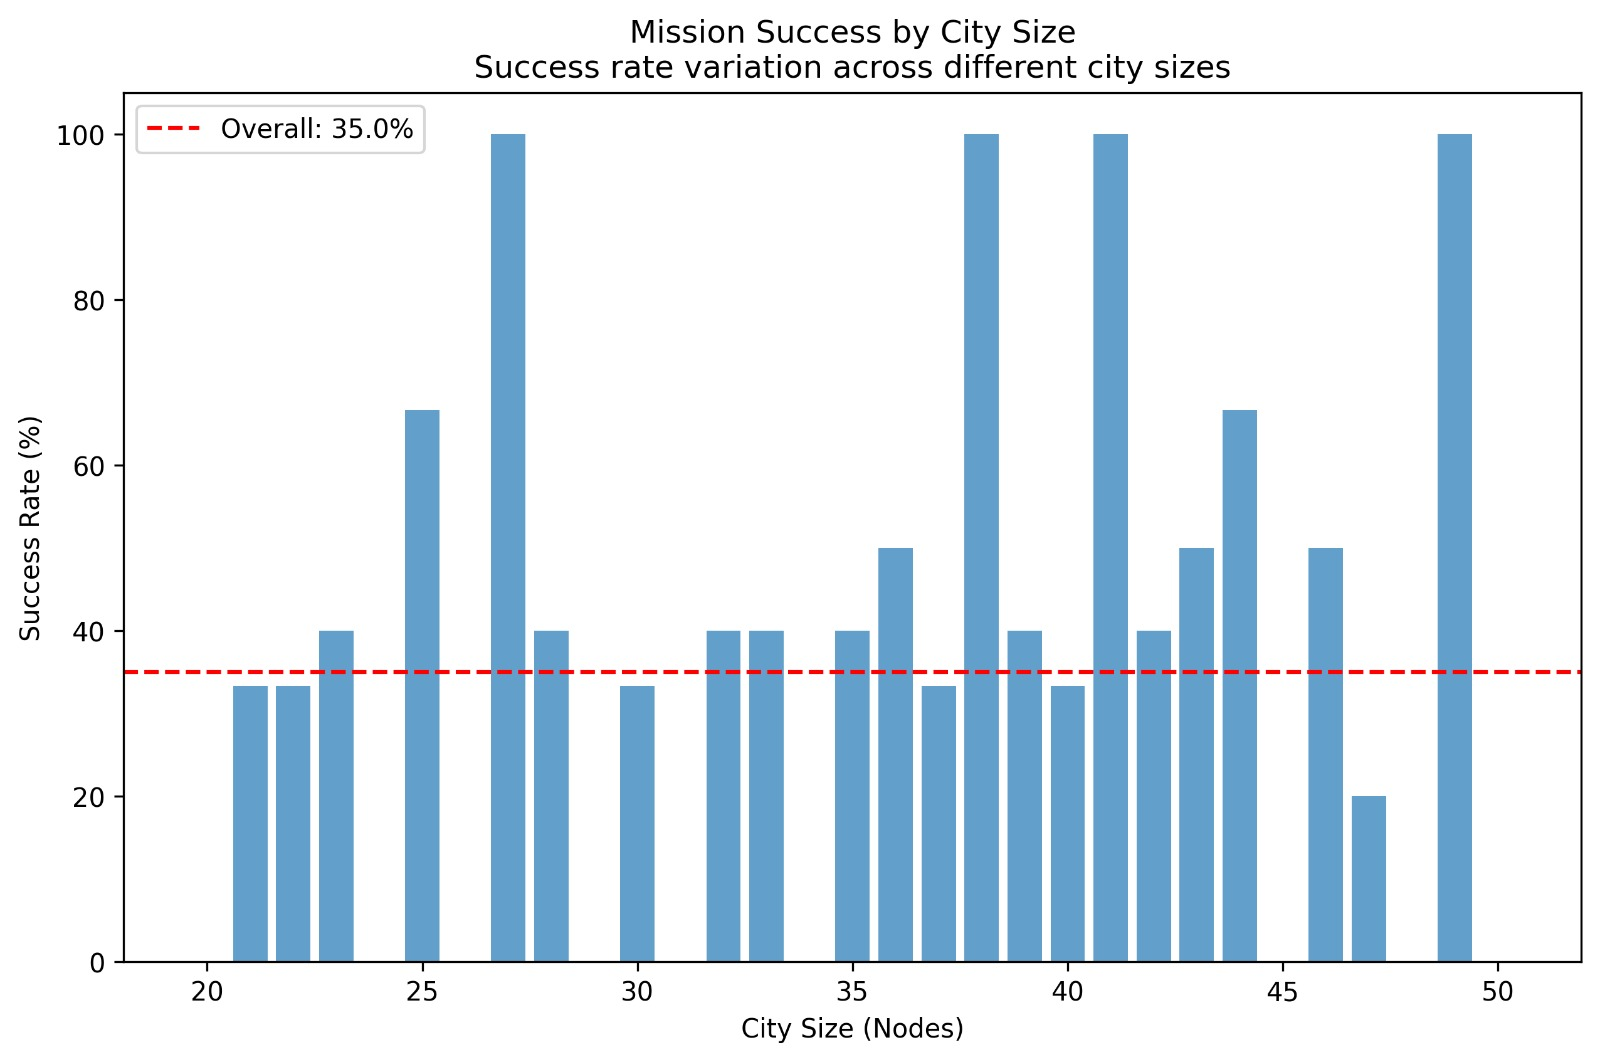
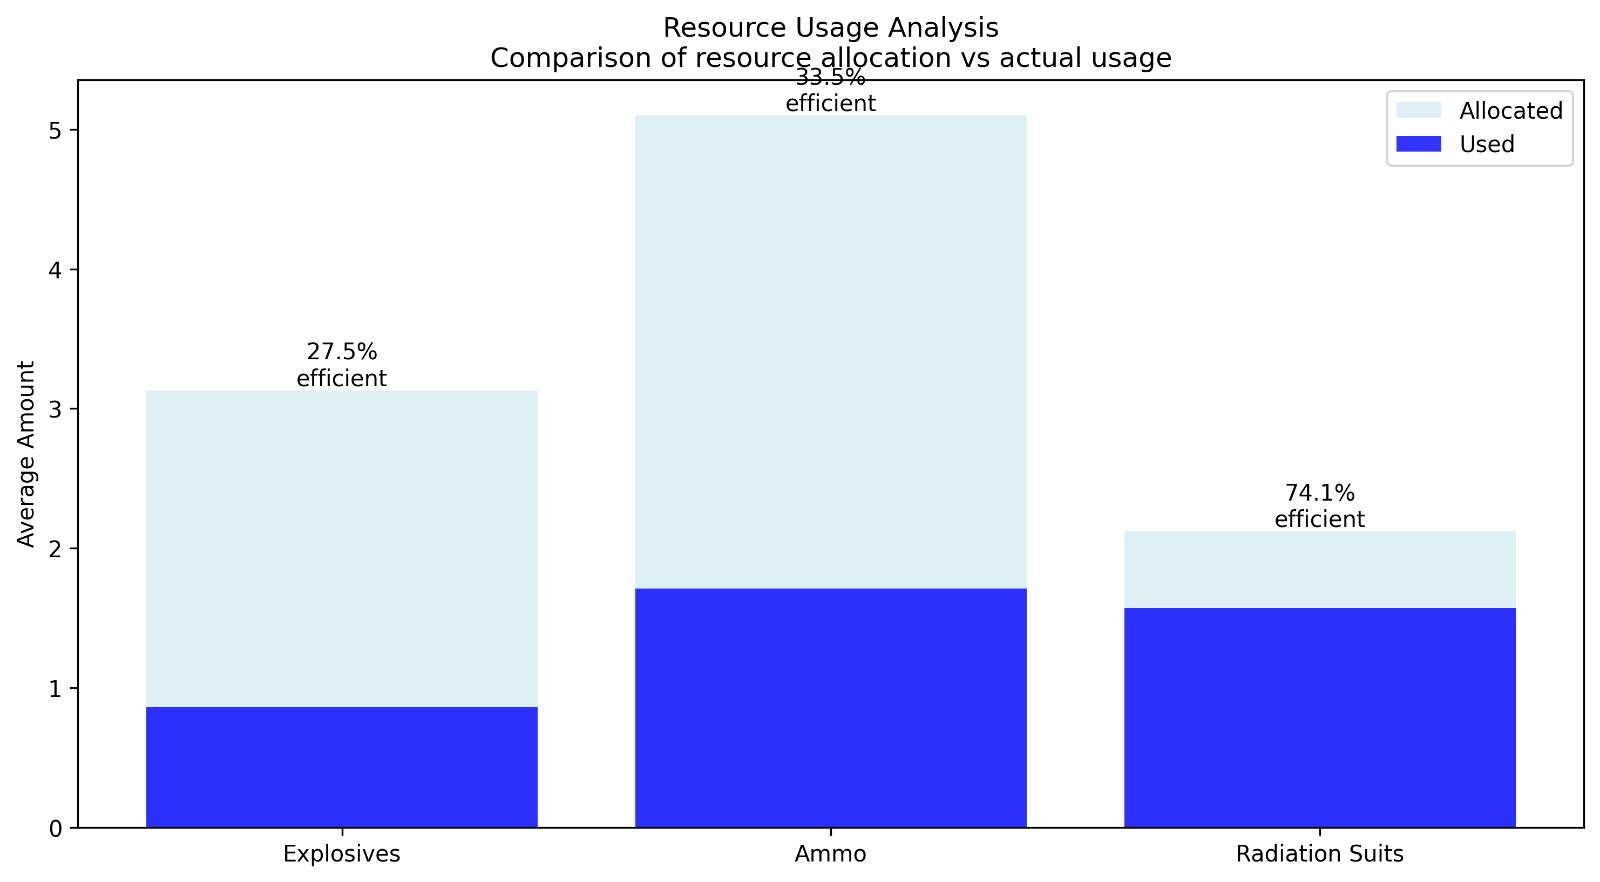